## Sequence

### Autoregressive Models

第一种策略，假设在现实情况下相当长的序列
$x_{t-1}, \ldots, x_1$可能是不必要的，
因此我们只需要满足某个长度为$\tau$的时间跨度，
即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。
当下获得的最直接的好处就是参数的数量总是不变的，
至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。
这种模型被称为*自回归模型*（autoregressive models），
因为它们是对自己执行回归。

### latent autoregressive models

第二种策略，
是保留一些对过去观测的总结$h_t$，
并且同时更新预测$\hat{x}_t$和总结$h_t$。
这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，
以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。
由于$h_t$从未被观测到，这类模型也被称为
*隐变量自回归模型*（latent autoregressive models）

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

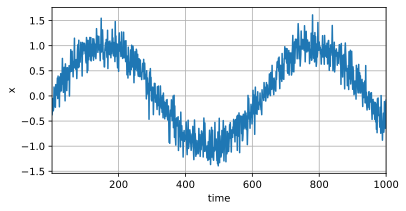

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                                       batch_size, is_train=True)

In [5]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weight)
    return net

loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
    
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.070166
epoch 2, loss: 0.059901
epoch 3, loss: 0.057009
epoch 4, loss: 0.058248
epoch 5, loss: 0.054426


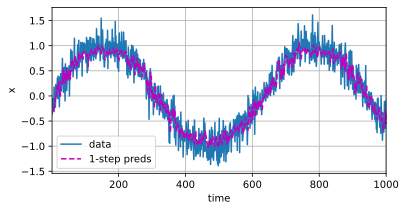

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

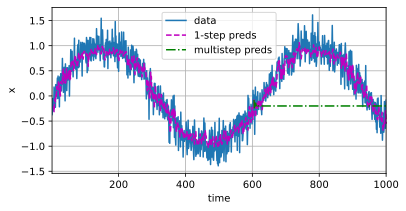

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [10]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau: i]).reshape((-1))

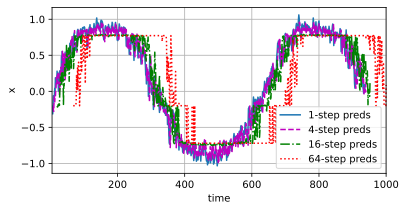

In [11]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps], 
         [features[:, (tau + i -1)].detach().numpy() for i in steps],
         'time', 'x', legend=[f'{i}-step preds' for i in steps],
         xlim=[5, 1000], figsize=(6, 3))

In [12]:
def test(tau):
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = x[i: T - tau + i]
    labels = x[tau:].reshape((-1, 1))

    batch_size, n_train = 16, 600
    train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                                batch_size, is_train=True)

    def get_net():
        net = nn.Sequential(nn.Linear(tau, 10),
                            nn.ReLU(),
                            nn.Linear(10, 1))
        net.apply(init_weight)
        return net

    net = get_net()
    print(f'tau={tau}')
    train(net, train_iter, loss, 5, 0.01)

    max_steps = 64
    features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
    for i in range(tau):
        features[:, i] = x[i: i + T - tau - max_steps + 1]
    for i in range(tau, tau + max_steps):
        features[:, i] = net(features[:, i - tau:i]).reshape(-1)

    steps = (1, 4, 16, 64)
    d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
            [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
            legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
            figsize=(6, 3))

tau=8
epoch 1, loss: 0.080034
epoch 2, loss: 0.068187
epoch 3, loss: 0.067205
epoch 4, loss: 0.057148
epoch 5, loss: 0.059196


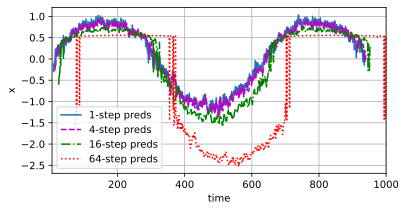

In [13]:
test(8)

tau=16
epoch 1, loss: 0.062935
epoch 2, loss: 0.059176
epoch 3, loss: 0.054704
epoch 4, loss: 0.051262
epoch 5, loss: 0.051131


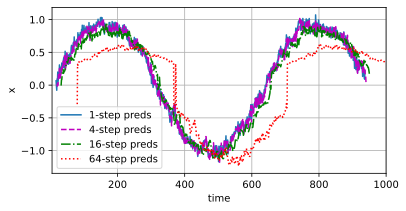

In [14]:
test(16)

tau=64
epoch 1, loss: 0.092599
epoch 2, loss: 0.084800
epoch 3, loss: 0.078458
epoch 4, loss: 0.063906
epoch 5, loss: 0.050679


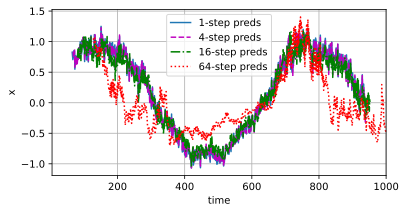

In [15]:
test(64)

[参考答案](https://www.cnblogs.com/AncilunKiang/p/17750444.html)

## Text Preprocessing

### Read the datasets

In [16]:
import collections
import re
from d2l import torch as d2l

In [17]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', 
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    # 正则表达式替换
    return [re.sub('[^A-Za-z\s]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数：{len(lines)}')
print(lines[0])
print(lines[-1])

# 文本总行数：3221
the time machine  by h  g  wells
of man


### Tokenization

In [18]:
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('笨蛋：未知词元类型' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### Vocabulary

In [19]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True) # 别忘记反转把小的放前面！

        # 未知词元索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx 
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
        
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
        
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
        
    @property
    def unk(self): # 未知词元索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
        
def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [20]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [21]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [22]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(174422, 28)

In [23]:
lines = read_time_machine()
tokens = tokenize(lines, 'word')
vocab = Vocab(tokens, min_freq=10)
corpus = [vocab[token] for line in tokens for token in line]

len(corpus), len(vocab)
print(vocab.idx_to_token[:10])

['<unk>', 'the', 'i', 'and', 'of', 'a', 'to', 'was', 'in', 'that']


[参考答案](https://www.cnblogs.com/AncilunKiang/p/17750838.html)

## Language Model

In [24]:
import random
import torch
from d2l import torch as d2l

In [25]:
tokens = d2l.tokenize(read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

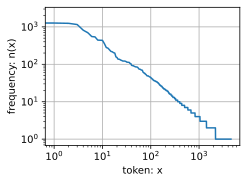

In [26]:
# 词频图
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

通过此图我们可以发现：词频以一种明确的方式迅速衰减。
将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。
这意味着单词的频率满足*齐普夫定律*（Zipf's law），
即第$i$个最常用单词的频率$n_i$为：

$$n_i \propto \frac{1}{i^\alpha},$$

等价于

$$\log n_i = -\alpha \log i + c,$$

其中$\alpha$是刻画分布的指数，$c$是常数。
这告诉我们想要通过计数统计和平滑来建模单词是不可行的，
因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。

In [27]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [28]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

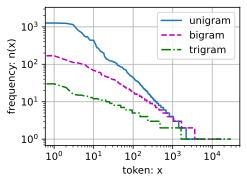

In [29]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

### Random Sampling

In [30]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [31]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X:', X, '\nY:', Y)

X: tensor([[26, 27, 28, 29, 30],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [17, 18, 19, 20, 21]])
X: tensor([[11, 12, 13, 14, 15],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [ 2,  3,  4,  5,  6]])
X: tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]])


### Sequence Sampling

In [32]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = (len(corpus) - offset - 1) // batch_size * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    print(Xs.shape)
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [33]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

torch.Size([28])
X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [34]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [35]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

[参考答案](https://blog.csdn.net/jerry_liufeng/article/details/121052058)

## RNN 

假设我们在时间步$t$有小批量输入$\mathbf{X}_t \in \mathbb{R}^{n \times d}$。
换言之，对于$n$个序列样本的小批量，
$\mathbf{X}_t$的每一行对应于来自该序列的时间步$t$处的一个样本。
接下来，用$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$
表示时间步$t$的隐藏变量。
与多层感知机不同的是，
我们在这里保存了前一个时间步的隐藏变量$\mathbf{H}_{t-1}$，
并引入了一个新的权重参数$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$，
来描述如何在当前时间步中使用前一个时间步的隐藏变量。
具体地说，当前时间步隐藏变量由当前时间步的输入
与前一个时间步的隐藏变量一起计算得出：

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

多添加了一项
$\mathbf{H}_{t-1} \mathbf{W}_{hh}$，
从而实例化。
从相邻时间步的隐藏变量$\mathbf{H}_t$和
$\mathbf{H}_{t-1}$之间的关系可知，
这些变量捕获并保留了序列直到其当前时间步的历史信息，
就如当前时间步下神经网络的状态或记忆，
因此这样的隐藏变量被称为*隐状态*（hidden state）。
由于在当前时间步中，
隐状态使用的定义与前一个时间步中使用的定义相同，
因此上式的计算是*循环的*（recurrent）。

In [36]:
import torch
from d2l import torch as d2l

隐状态中
$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$的计算，
相当于$\mathbf{X}_t$和$\mathbf{H}_{t-1}$的拼接
与$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接的矩阵乘法，（我们沿列（轴1）拼接矩阵`X`和`H`，
沿行（轴0）拼接矩阵`W_xh`和`W_hh`）
下面我们来验证一下。

In [37]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))

In [38]:
A = torch.matmul(X, W_xh) + torch.matmul(H, W_hh)
B = torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))
print(A)
print(B)
A == B  # 结果肯定是不等于，因为float32

tensor([[-0.0575, -3.4218, -1.4658, -2.1747],
        [-2.0816,  2.1259, -7.3348,  1.0876],
        [-2.1921,  6.0816, -0.4906,  0.9439]])
tensor([[-0.0575, -3.4218, -1.4658, -2.1747],
        [-2.0816,  2.1259, -7.3348,  1.0876],
        [-2.1921,  6.0816, -0.4906,  0.9439]])


tensor([[False,  True,  True,  True],
        [False, False,  True, False],
        [False,  True, False, False]])

一个更好的语言模型应该能让我们更准确地预测下一个词元。
因此，它应该允许我们在压缩序列时花费更少的比特。
所以我们可以通过一个序列中所有的$n$个词元的交叉熵损失的平均值来衡量：

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$

其中$P$由语言模型给出，
$x_t$是在时间步$t$从该序列中观察到的实际词元。
这使得不同长度的文档的性能具有了可比性。
由于历史原因，自然语言处理的科学家更喜欢使用一个叫做*困惑度*（perplexity）的量。
简而言之，它是上式的指数：

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$


[参考](https://blog.csdn.net/jerry_liufeng/article/details/121191221)

## RNN-Implementation 

In [39]:
import re
import time
import random
import math
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import collections

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', 
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

### Something Achived Before

In [40]:
def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    # 正则表达式替换
    return [re.sub('[^A-Za-z\s]+', ' ', line).strip().lower() for line in lines]

In [41]:
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('笨蛋：未知词元类型' + token)

In [42]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = d2l.Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [43]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [44]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = (len(corpus) - offset - 1) // batch_size * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    print(Xs.shape)
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [45]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [46]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

### Continue

In [47]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

### Convert to One_Hot Code

In [48]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的(**小批量数据形状是二维张量：
（批量大小，时间步数）。**)
`one_hot`函数将这样一个小批量数据转换成三维张量，
张量的最后一个维度等于词表大小`len(vocab)`。
我们经常转换输入的维度，以便获得形状为
（时间步数，批量大小，词表大小）的输出。
这将使我们能够更方便地通过最外层的维度，
一步一步地更新小批量数据的隐状态。


In [49]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### Initialize the params

In [50]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [51]:
# 返回隐状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [52]:
# 计算过程
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)  # 创建单元素元组

In [53]:
class RNNModel:
    def __init__(self, vocab_size, num_hiddens, device, 
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
        
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [54]:
# Test
num_hiddens = 512
net_RNN = RNNModel(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                   init_rnn_state, rnn)
state = net_RNN.begin_state(X.shape[0], d2l.try_gpu())
print(state)
Y, new_state = net_RNN(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),)


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [55]:
print(new_state)

(tensor([[ 0.0215, -0.0158, -0.0128,  ..., -0.0034,  0.0069, -0.0021],
        [-0.0109, -0.0075, -0.0002,  ..., -0.0087, -0.0119, -0.0075]],
       device='cuda:0', grad_fn=<TanhBackward0>),)


In [56]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [57]:
predict_ch8('time traveller', 10, net_RNN, vocab, d2l.try_gpu())

'time travellerqbcjn wayb'

### Grad Clipping

有时梯度可能很大，从而优化算法可能无法收敛。
我们可以通过降低$\eta$的学习率来解决这个问题。
但是如果我们很少得到大的梯度呢？
在这种情况下，这种做法似乎毫无道理。
一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径
（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。
如下式：

**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**

通过这样做，我们知道梯度范数永远不会超过$\theta$，
并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。
它还有一个值得拥有的副作用，
即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响，
这赋予了模型一定程度的稳定性。
梯度裁剪提供了一个快速修复梯度爆炸的方法，
虽然它并不能完全解决问题，但它是众多有效的技术之一。


In [58]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))  # 计算范数
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### Train

它与我们训练softmax模型的方式有三个不同之处。

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。
   这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型，这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，
我们只在每个迭代周期的开始位置初始化隐状态。
由于下一个小批量数据中的第$i$个子序列样本
与当前第$i$个子序列样本相邻，
因此当前小批量数据最后一个样本的隐状态，
将用于初始化下一个小批量数据第一个样本的隐状态。
这样，存储在隐状态中的序列的历史信息
可以在一个迭代周期内流经相邻的子序列。
然而，在任何一点隐状态的计算，
都依赖于同一迭代周期中前面所有的小批量数据，
这使得梯度计算变得复杂。
为了降低计算量，在处理任何一个小批量数据之前，
我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，
因此需要为每个迭代周期重新初始化隐状态。
与`softmax_scratch`中的
`train_epoch_ch3`函数相同，
`updater`是更新模型参数的常用函数。
它既可以是从头开始实现的`d2l.sgd`函数，
也可以是深度学习框架中内置的优化函数。

In [59]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和，词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [60]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters())
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    # 训练和识别
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter
        )
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            time.sleep(1)
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒，在 {str(device)}上训练')
    print(predict('time traveller'))
    print(predict('traveller')) 
    print(predict('the')) 

困惑度 1.0, 102731.0 词元/秒，在 cuda:0上训练
time traveller  for so it will be convenient to speak of himwas 
traveller   but now you begin to seethe object of my invest
the time dimension  or even turn aboutand travel the 


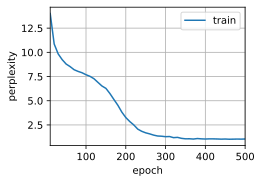

In [61]:
num_epochs, lr = 500, 1
train_ch8(net_RNN, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.5, 96004.5 词元/秒，在 cuda:0上训练
time traveller  after the pauserequired for the proper assimilat
traveller  after the pauserequired for the proper assimilat
the very young manthat shall travel indifferently in 


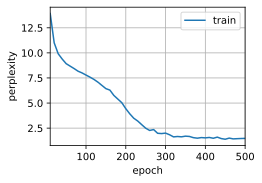

In [62]:
net_random = RNNModel(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net_random, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

In [1]:
# 《星球大战》数据加载， 参考https://blog.csdn.net/jerry_liufeng/article/details/121191551
def read_book(dir):
    """这里的预处理操作比较暴力，将标点符号和特殊字符全部剔除了，只剩下了26个字母和空格"""
    with open(dir,'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

def tokenize(lines,token='word'):
    if token=="word":
        return [line.split() for line in lines]
    elif token =="char":
        return [list(line) for line in lines]
    else:
        print("Error:未知令牌类型："+token)

        lines = read_book('./data/RNN/36-0.txt') 
        
def count_corpus(tokens):
    """统计标记的频率：这里的tokens是1D列表或者2D列表"""
    if len(tokens) ==0 or isinstance(tokens[0],list):
        # 将tokens展平成使用标记填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """构建文本词表"""
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
            reserved_tokens = []
        # 根据出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(),key=lambda x:x[1],reverse=True)
        
        # 未知标记的索引为0
        self.unk , uniq_tokens = 0, ['<unk>']+reserved_tokens
        uniq_tokens += [token for token,freq in self.token_freqs
                       if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token,self.token_to_idx = [],dict() # 根据索引找标记和根据标记找索引
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token)-1
            
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        """转换到一个一个的item进行输出"""
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        """如果是单个index直接输出，如果是list或者tuple迭代输出"""
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
def load_corpus_book(max_tokens=-1):
    """返回book数据集中的标记索引列表和词汇表"""
    lines = read_book('./data/RNN/36-0.txt')
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    # 因为数据集中每一个文本行，不一定是一个句子或者段落
    # 所以将所有文本行展平到一个列表之中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens >0:
        corpus = corpus[:max_tokens]
    return corpus,vocab

def seq_data_iter_random(corpus,batch_size,num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括`num_steps - 1`
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为`num_steps`的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从`pos`位置开始的长度为`num_steps`的序列
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，`initial_indices`包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
        
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0,num_steps)
    num_tokens = ((len(corpus)- offset -1)//batch_size)*batch_size
    Xs = torch.tensor(corpus[offset:offset+num_tokens])
    Ys = torch.tensor(corpus[offset+1:offset+num_tokens+1])
    Xs,Ys = Xs.reshape(batch_size,-1),Ys.reshape(batch_size,-1)
    num_batches = Xs.shape[1]//num_steps
    for i in range(0,num_steps*num_batches,num_steps):
        X = Xs[:,i:i+num_steps]
        Y = Ys[:,i:i+num_steps]
        yield X,Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_book(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
        
# 定义函数load_data_book同时返回数据迭代器和词汇表
def load_data_book(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,max_tokens)
    return data_iter, data_iter.vocab


## RNN implemented by API 

In [63]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### Define the Model

In [78]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

我们**使用张量来初始化隐状态**，它的形状是（隐藏层数，批量大小，隐藏单元数）。


In [79]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [80]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

与`rnn_scratch`类似，
**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**。

注意，`rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [81]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [82]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time travellerzmgzmgzmgz'

困惑度 17.1, 433750.0 词元/秒，在 cuda:0上训练
time traveller                                                  
traveller                                                  
the                                                  


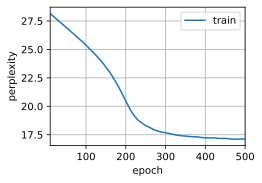

In [83]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [85]:
num_hiddens1 = 1024
rnn_layer1 = nn.RNN(len(vocab), num_hiddens1)

In [86]:
device = d2l.try_gpu()
net1 = RNNModel(rnn_layer1, vocab_size=len(vocab))
net1 = net1.to(device)
predict_ch8('time traveller', 10, net1, vocab, device)

'time traveller<unk>ccpdddcpd'

困惑度 17.0, 279304.4 词元/秒，在 cuda:0上训练
time traveller                                                  
traveller                                                  
the                                                  


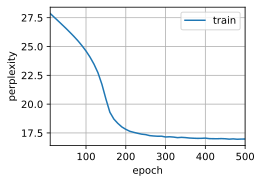

In [87]:
num_epochs, lr = 500, 1
train_ch8(net1, train_iter, vocab, lr, num_epochs, device)

[参考](https://blog.csdn.net/qq_43941037/article/details/133834109)

## BPTT 
（backpropagation through time）

## 循环神经网络的梯度分析

我们从一个描述循环神经网络工作原理的简化模型开始，
此模型忽略了隐状态的特性及其更新方式的细节。
这里的数学表示没有像过去那样明确地区分标量、向量和矩阵，
因为这些细节对于分析并不重要，
反而只会使本小节中的符号变得混乱。

在这个简化模型中，我们将时间步$t$的隐状态表示为$h_t$，
输入表示为$x_t$，输出表示为$o_t$。
回想一下我们在`rnn_w_hidden_states`中的讨论，
输入和隐状态可以拼接后与隐藏层中的一个权重变量相乘。
因此，我们分别使用$w_h$和$w_o$来表示隐藏层和输出层的权重。
每个时间步的隐状态和输出可以写为：

（1）
$$\begin{aligned}h_t &= f(x_t, h_{t-1}, w_h),\\o_t &= g(h_t, w_o),\end{aligned}$$  

其中$f$和$g$分别是隐藏层和输出层的变换。
因此，我们有一个链
$\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$，  
它们通过循环计算彼此依赖。
前向传播相当简单，一次一个时间步的遍历三元组$(x_t, h_t, o_t)$，
然后通过一个目标函数在所有$T$个时间步内
评估输出$o_t$和对应的标签$y_t$之间的差异：

（2）
$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_h, w_o) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t).$$ 

对于反向传播，问题则有点棘手，
特别是当我们计算目标函数$L$关于参数$w_h$的梯度时。
具体来说，按照链式法则：

（3）
$$\begin{aligned}\frac{\partial L}{\partial w_h}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_h}  \\& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_o)}{\partial h_t}  \frac{\partial h_t}{\partial w_h}.\end{aligned}$$  

在（3）式中乘积的第一项和第二项很容易计算，
而第三项$\partial h_t/\partial w_h$是使事情变得棘手的地方，
因为我们需要循环地计算参数$w_h$对$h_t$的影响。
根据前式中的递归计算，
$h_t$既依赖于$h_{t-1}$又依赖于$w_h$，
其中$h_{t-1}$的计算也依赖于$w_h$。
因此，使用链式法则产生：

（4）
$$\frac{\partial h_t}{\partial w_h}= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_h}.$$  

为了导出上述梯度，假设我们有三个序列$\{a_{t}\},\{b_{t}\},\{c_{t}\}$，
当$t=1,2,\ldots$时，序列满足$a_{0}=0$且$a_{t}=b_{t}+c_{t}a_{t-1}$。
对于$t\geq 1$，就很容易得出：

（5）
$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}.$$ 

基于下列公式替换$a_t$、$b_t$和$c_t$：

（6）
$$\begin{aligned}a_t &= \frac{\partial h_t}{\partial w_h},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}},\end{aligned}$$  

公式（4）中的梯度计算
满足$a_{t}=b_{t}+c_{t}a_{t-1}$。
因此，对于每个（5），
我们可以使用下面的公式移除（4）中的循环计算

（7）
$$\frac{\partial h_t}{\partial w_h}=\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_h)}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_h)}{\partial w_h}.$$  

虽然我们可以使用链式法则递归地计算$\partial h_t/\partial w_h$，
但当$t$很大时这个链就会变得很长。
我们需要想想办法来处理这一问题，如使用截断时间步，或者随机截断

### 截断时间步 ###

我们可以在$\tau$步后截断
（7）中的求和计算。
这是我们到目前为止一直在讨论的内容，
例如在`rnn_scratch`中分离梯度时。
这会带来真实梯度的*近似*，
只需将求和终止为$\partial h_{t-\tau}/\partial w_h$。
在实践中，这种方式工作得很好。
它通常被称为截断的通过时间反向传播 （`Jaeger.2002`）。
这样做导致该模型主要侧重于短期影响，而不是长期影响。
这在现实中是可取的，因为它会将估计值偏向更简单和更稳定的模型。

### 随机截断 ###

最后，我们可以用一个随机变量替换$\partial h_t/\partial w_h$，
该随机变量在预期中是正确的，但是会截断序列。
这个随机变量是通过使用序列$\xi_t$来实现的，
序列预定义了$0 \leq \pi_t \leq 1$，
其中$P(\xi_t = 0) = 1-\pi_t$且$P(\xi_t = \pi_t^{-1}) = \pi_t$，
因此$E[\xi_t] = 1$。
我们使用它来替换（4）中的
梯度$\partial h_t/\partial w_h$得到：

$$z_t= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_h}.$$

从$\xi_t$的定义中推导出来$E[z_t] = \partial h_t/\partial w_h$。
每当$\xi_t = 0$时，递归计算终止在这个$t$时间步。
这导致了不同长度序列的加权和，其中长序列出现的很少，
所以将适当地加大权重。
这个想法是由塔莱克和奥利维尔（`Tallec.Ollivier.2017`）提出的。

[参考答案](https://www.cnblogs.com/CLGYPYJ/p/17574340.html)